# Libor Curve Bootstrapper

The goal of the project is to build a bootstrapping procedure whose output will be a forward libor curve (an instance of the python class ForwardRateCurve) in the “multi-curve” framework. The input parameters to derive this curve are:

* The par rate of a set of Overnight Index Swaps (i.e. their market quotation)
* The fixing value of the libor rate at the “evaluation date”
* The par rate of a set of Swap (i.e. their market quotation), whose underlying libor rate has 6 months tenor (i.e. the floating leg pays every six months) and the fixed coupon is paid annually

The resulting class will be used to compute the forward libor rate at some future dates and plot the results.

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

In [1]:
import pandas as pd
from datetime import date

today = date(2019, 10, 31)
libor_tenor = 6
libor_fixing_value = 0.00351

ois_quotes = pd.read_csv("ois_quotes.csv").to_dict('records')
irs_quotes = pd.read_csv("irs_quotes_proj6.csv").to_dict('records')

In [2]:
from finmarkets import OvernightIndexSwap, DiscountCurve, generate_swap_dates
from dateutil.relativedelta import relativedelta

pillar_dates = [today]
swaps = []
for quote in ois_quotes:
    swaps.append(OvernightIndexSwap(1, generate_swap_dates(today, quote['maturity']), quote['rate']))
    pillar_dates.append(today + relativedelta(months=quote['maturity']))

pillar_dates = sorted(pillar_dates)
print (pillar_dates)

[datetime.date(2019, 10, 31), datetime.date(2019, 11, 30), datetime.date(2019, 12, 31), datetime.date(2020, 1, 31), datetime.date(2020, 2, 29), datetime.date(2020, 3, 31), datetime.date(2020, 4, 30), datetime.date(2020, 5, 31), datetime.date(2020, 6, 30), datetime.date(2020, 7, 31), datetime.date(2020, 8, 31), datetime.date(2020, 9, 30), datetime.date(2020, 10, 31), datetime.date(2021, 1, 31), datetime.date(2021, 4, 30), datetime.date(2021, 7, 31), datetime.date(2021, 10, 31), datetime.date(2022, 10, 31), datetime.date(2023, 10, 31), datetime.date(2024, 10, 31), datetime.date(2025, 10, 31), datetime.date(2026, 10, 31), datetime.date(2027, 10, 31), datetime.date(2028, 10, 31), datetime.date(2029, 10, 31), datetime.date(2030, 10, 31), datetime.date(2031, 10, 31), datetime.date(2034, 10, 31), datetime.date(2039, 10, 31), datetime.date(2044, 10, 31), datetime.date(2049, 10, 31)]


In [3]:
import numpy as np

def obj_func(x):
    x = np.insert(x, 0, 1)
    curve = DiscountCurve(today, pillar_dates, x)
    
    npv = 0 
    for s in swaps:
        npv += s.npv(curve)**2
        
    return npv

In [4]:
from scipy.optimize import minimize

x0 = [0.5 for _ in range(len(pillar_dates)-1)]
bounds = [(0.001, 100.) for _ in range(len(pillar_dates)-1)]

result = minimize(obj_func, x0, bounds=bounds)

In [5]:
print (result)
print (obj_func(x0))
print (result.fun)

      fun: 6.3136555793165805e-12
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.15544451e-07,  3.38701895e-07,  3.60637867e-07,  3.81965250e-07,
        4.05073324e-07,  4.27833370e-07,  4.50409457e-07,  4.73642130e-07,
        5.00820844e-07,  5.27142195e-07,  5.54961135e-07, -2.12977131e-06,
        5.06605946e-07,  6.06711537e-07,  7.23849672e-07, -2.49759694e-06,
       -2.14799131e-06, -1.54816410e-06, -8.93471510e-07, -2.69831922e-07,
        2.04343781e-07,  5.23315116e-07,  6.84265905e-07,  7.37812760e-07,
        6.81507045e-07,  5.98057029e-07,  3.21497181e-07,  6.14508465e-07,
        4.95095226e-07,  4.24818127e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 248
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.99991183, 0.99980703, 0.99970637, 0.99960709, 0.99949801,
       0.99938886, 0.99927891, 0.99916393, 0.99902697, 0.99889163,
       0.9987456 , 0.99859787, 0.99806939, 0.9974824

In [6]:
x = np.insert(result.x, 0, 1)
discount_curve = DiscountCurve(today, pillar_dates, x)

In [7]:
from finmarkets import InterestRateSwap, ForwardRateCurve

irs = []
libor_pillar_dates = [today]
for i in irs_quotes:
    irs.append(InterestRateSwap(today, 1, i['rate'], libor_tenor, i['maturity']//12))
    libor_pillar_dates.append(today + relativedelta(months=i['maturity']))
    
libor_pillar_dates = sorted(libor_pillar_dates)

In [11]:
def libor_obj_func(x):
    
    x = np.insert(x, 0, libor_fixing_value)
    libor_curve = ForwardRateCurve(libor_pillar_dates, x)
    
    npv = 0
    for i in irs:
        npv += i.npv(discount_curve, libor_curve) ** 2
    
    return npv

In [12]:
fwd0 = [0.01 for _ in range(len(libor_pillar_dates)-1)]
fwd_bounds = [(-100, 100) for _ in range(len(libor_pillar_dates)-1)]

fwd_result = minimize(libor_obj_func, fwd0, bounds=fwd_bounds)

In [13]:
print (fwd_result)
print (libor_obj_func(fwd0))
print (libor_obj_func(fwd_result.x))

      fun: 1.4260920575195777e-07
 hess_inv: <33x33 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.37147207e-04,  2.40344872e-04,  2.20811350e-04,  1.79671071e-04,
        1.33051891e-04,  9.60996921e-05,  7.52565963e-05,  1.05123415e-04,
        1.28812982e-04,  1.37174294e-04,  7.75327306e-05, -2.61986523e-08,
       -7.16579619e-05, -1.06677137e-04, -1.33203402e-04, -1.09441446e-04,
       -1.16959936e-04, -1.59703213e-04, -2.00357343e-04, -2.32481429e-04,
       -2.35239450e-04, -1.85492201e-04, -1.72975335e-04, -2.32053237e-04,
       -2.46499541e-04, -2.88892754e-04, -1.24007499e-04, -7.59467571e-05,
       -1.38807441e-04, -2.33208778e-04, -3.64040510e-04, -6.01694439e-04,
       -3.92350682e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1258
      nit: 32
     njev: 37
   status: 0
  success: True
        x: array([0.00487014, 0.00850021, 0.01387818, 0.01888693, 0.02300063,
       0.02622847, 0.02865762, 0.03076312, 0.03289689, 0.03

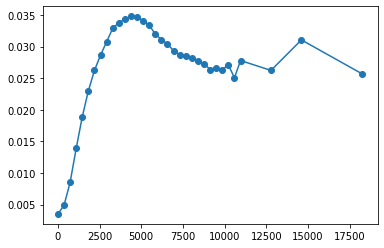

In [17]:
from datetime import date

x = np.insert(fwd_result.x, 0, libor_fixing_value)
fwd_curve =  ForwardRateCurve(libor_pillar_dates, x)

from matplotlib import pyplot as plt
plt.plot(fwd_curve.pillar_days, fwd_curve.pillar_rates, marker='o')
plt.show()
